# Get GOES
## Create a Machine Learning Ready Dataset With GOES imagery

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Get_GOES/blob/main/Get_GOES.ipynb)

![](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/DayNightCloudMicroCombo/20241232111_GOES16-ABI-CONUS-DayNightCloudMicroCombo-625x375.jpg)

#### Notebook Creator: Rey Koki rey.koki@noaa.gov

Cooperative Institute for Research for Environmental Sciences ([CIRES](https://cires.colorado.edu/))

NOAA Global Systems Laboratory ([GSL](https://gsl.noaa.gov/))

In [1]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone https://github.com/reykoki/Get_GOES.git
    !rm Get_GOES/Get_GOES.ipynb
    !mv Get_GOES/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
import time
from datetime import datetime
import pytz
import wget
from IPython.display import Image, display
import sys
sys.path.insert(1, './scripts')
from helper_functions import *

# Develop a Machine Learning Ready Dataset from GOES Satellite Imagery
# 1. Data
We will take data from the GOES-EAST Advanced Baseline Imager (ABI) and generate a datasample that is geographically localized for a given latitude and longitude.
#### Data Objectives
1. Given a date and time and location, download the corresponding [GOES satellite imagery from AWS](https://registry.opendata.aws/noaa-goes/)
2. Process and visualize a True Color composite for the Continental US (CONUS)
3. Geographically localize the GOES satellite imagery

## 1.1 GOES Satellite Imagery

For a comprehensive technical guide to GOES satellites and their instruments, refer to the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).

The GOES series Advanced Baseline Imager (ABI) provides data at 16 channels that cover visible (C01-C02), near-IR (C03-C06) and IR (C07-C16) bands. 


| Band | Descirption | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :-: | :-: | :-: |
| [C01](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band01.pdf) | Blue visible | 0.47 | 1 |
| [C02](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band02.pdf) | Red visible | 0.64 | 0.5 |
| [C03](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band03.pdf) | Veggie near infrared | 0.865 | 1 |
| [C04](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band04.pdf) | Cirrus | 1.378 | 2 |
| [C05](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band05.pdf) | Snow/Ice | 1.61 | 1 |
| [C06](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band06.pdf) | Cloud particle | 2.24 | 2 |
| [C07](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band07.pdf) | Shortwave IR | 3.9 | 2 |
| [C08](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf) | upper-level water vapor | 6.2 | 2 |
| [C09](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf) | mid-level water vapor | 6.9 | 2 |
| [C10](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf) | lower-level water vapor | 7.3 | 2 |
| [C11](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band11.pdf) | IR cloud phase | 8.5 | 2 |
| [C12](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band12.pdf) | ozone | 9.6 | 2 |
| [C13](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band13.pdf) | clean longwave IR | 10.35 | 2 |
| [C14](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf) | longwave IR | 11.2 | 2 |
| [C15](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band15.pdf) | dirty longwave IR | 12.3 | 2 |
| [C16](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band16.pdf) | CO$_2$ | 13.3 | 2 |

To create a true color image, we use the following bands from the Advanced Baseline Imager Level 1b CONUS (ABI-L1b-RadC) product.

A new ABI-L1b-RadC data file is produced every 5 minutes from both GOES-East and GOES-West and provided in netCDF4 format. 

![GOES-16](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif "GOES")

### 1.1.1 Grab GOES Satellite NetCDF files

From the datetime string, we download all 16 GOES-East band netcdf files from the [AWS repository](https://registry.opendata.aws/noaa-goes/). See code in `./scripts/grab_goes.py` for more details on how to use [sfs3](https://github.com/fsspec/s3fs) do this.

Use the format `YYYY/MM/DD HH:MM` to specify the time you'd like to grab imagery for

In [4]:
dt_str = '2023/09/24 21:00'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object

In [6]:
from grab_goes import * # ./scripts/grab_goes.py
sat_fns = download_goes(dt)

for the datetime 2023-09-24 21:00:00+00:00:
sunrise is at: 2023-09-24 14:08:24+00:00
sunset is at: 2023-09-23 22:38:24+00:00
OR_ABI-L1b-RadC-M6C01_G16_s20232672101174_e20232672103547_c20232672103581.nc already exists
OR_ABI-L1b-RadC-M6C02_G16_s20232672101174_e20232672103547_c20232672103575.nc already exists
OR_ABI-L1b-RadC-M6C03_G16_s20232672101174_e20232672103547_c20232672103595.nc already exists
OR_ABI-L1b-RadC-M6C04_G16_s20232672101174_e20232672103547_c20232672103584.nc already exists
OR_ABI-L1b-RadC-M6C05_G16_s20232672101174_e20232672103547_c20232672103592.nc already exists
OR_ABI-L1b-RadC-M6C06_G16_s20232672101174_e20232672103552_c20232672103587.nc already exists
OR_ABI-L1b-RadC-M6C07_G16_s20232672101174_e20232672103559_c20232672103598.nc already exists
OR_ABI-L1b-RadC-M6C08_G16_s20232672101174_e20232672103547_c20232672104027.nc already exists
OR_ABI-L1b-RadC-M6C09_G16_s20232672101174_e20232672103552_c20232672104023.nc already exists
OR_ABI-L1b-RadC-M6C10_G16_s20232672101174_e2023

## 1.2 True Color GOES Imagery

For this part of the tutorial, we will visualize GOES data using the first three bands to create a true color image.

We use the [satpy](https://satpy.readthedocs.io/en/latest/) library to read and augment our satellite data as seen in the image below.

![](https://raw.githubusercontent.com/reykoki/Get_GOES/main/figures/processing.png)

### 1.2.1 True Color Composite

We apply a composite of corrections based on algorithms to create a [CIMSS True Color](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) compositition for GOES ABI data. Additional composites available in the satpy library for the ABI instrument data can be found [here](https://github.com/pytroll/satpy/blob/main/satpy/etc/composites/abi.yaml).

The corrections applied using the CIMSS True Color composite:
- **true color** - correction to make the image look closer to what our eyes would see (it uses a combination of C01, C02 and C03 to make an approximation to green).
- **solar zenith angle** - correction for atmopsheric interactions with the light due to the solar zenith angle.
- **rayleigh scattering** - correction for how different wavelengths scatter off of particular atmposheric particles.



In [2]:
composite = ['cimss_true_color_sunz_rayleigh'] # define the true color composite

### 1.2.2 Lambert Conformal Conic Projection

Additionally, we transform the image onto a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) in order to reduce the distortion created by the [geostationary azimuthal projection](https://proj.org/en/9.2/operations/projections/geos.html).

In [38]:
import cartopy.crs as ccrs
def get_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj
extent=[-2.4e6, -1.5e6, 2.3e6, 1.4e6] # extent for CONUS in meters for LCC projection

### 1.2.3 Get Satpy Scene Object

In [16]:
from satpy import Scene
from pyresample import create_area_def

# get the Satpy Scene object
def get_scn(fns, to_load, extent, proj, res=3000, reader='abi_l1b'):
    scn = Scene(reader=reader, filenames=fns)
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    new_scn = scn.resample(my_area)
    return new_scn
    
res = 5000 # 5km resolution
scn = get_scn(sat_fns, composite, extent, lcc_proj, res) # get satpy scn object
crs = scn[composite[0]].attrs['area'].to_cartopy_crs() # the crs object will have the area extent for plotting

#### ***NOTE:*** this block will a few moments to run while it applies the projection transformation and corrections

In [17]:
def get_RGB(scn, composite):                                                                                                                                                                  
    data = scn.save_dataset(composite, compute=False)                                                                                                                                         
    R = data[0][0]                                                                                                                                                                            
    G = data[0][1]                                                                                                                                                                            
    B = data[0][2]                                                                                                                                                                            
    # reorder before computing for plotting                                                                                                                                                   
    RGB = np.dstack([R, G, B])                                                                                                                                                                
    RGB = RGB.compute() # computationally expensive part                                                                                                                                                                       
    return RGB
RGB = get_RGB(scn, composite[0]) # from the scene object, extract RGB data for plotting


### 1.2.4 Plot True Color Projected CONUS

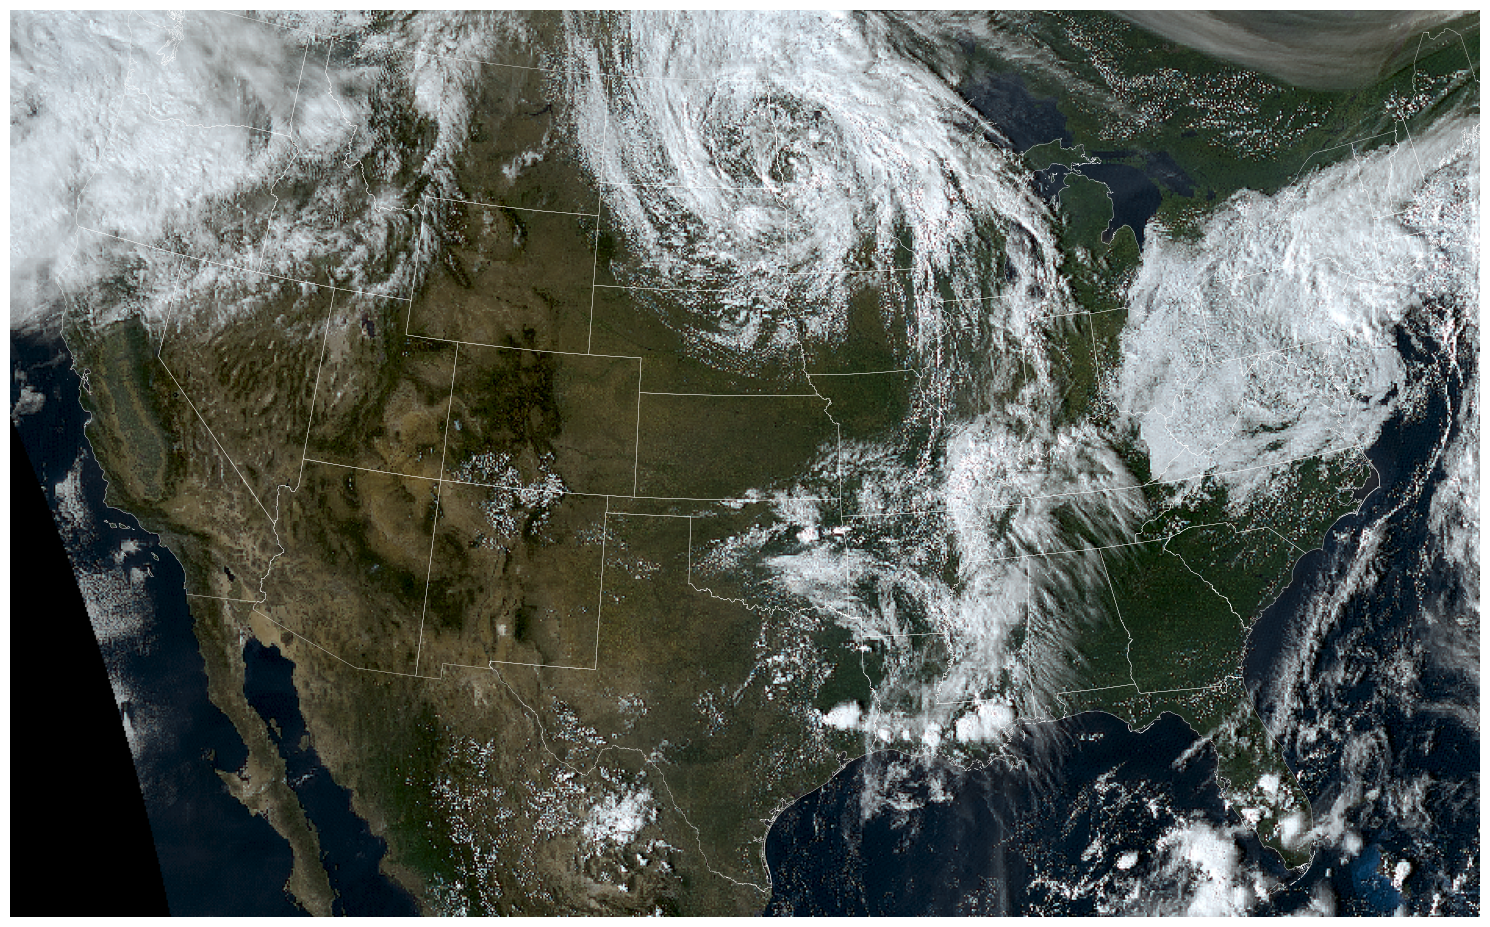

In [18]:
def plot_CONUS(data, crs):
    states = get_states(crs)
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()
plot_CONUS(RGB, crs)

## 1.3 Subsample the Image

At 2km resolution, the 3-channel CONUS satellite imagery contains 180 million pixels. With an increase in the number of pixels, there is a increase in the computational cost to run a machine learning model. For efficiency, we will work with images sized down to ~200,000 pixels but still cover 250 km$^2$.

### Save data

We save the imagery in tif format that can easily be loaded into a machine learning model. Coordinate data is saved for plotting.

In [35]:
def save_data(data, band, fn_head):
    tif_fn_data = data_dir + 'data/{}_{}.tif'.format(band, fn_head)
    skimage.io.imsave(tif_fn_data, data)

def save_coords(lat, lon, fn_head):
    tif_fn_coords = data_dir + 'coords/{}.tif'.format(fn_head)
    coords_layers = np.dstack([lat, lon])
    skimage.io.imsave(tif_fn_coords, coords_layers)

### Define center of image

In [77]:
lat = '40.0'
lon = '-105.27'

### 1.3.1. Raw Band Imagery

In [46]:
def get_extent(lat, lon, res, img_size=126):
    lcc_proj = pyproj.Proj(get_proj())
    center = lcc_proj(lon,lat)
    dist = int(img_size/2*res)
    x0 = center[0] - dist
    y0 = center[1] - dist
    x1 = center[0] + dist
    y1 = center[1] + dist
    return [x0, y0, x1, y1]

def create_raw(sat_fns, lat, lon, res=4000):
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    bands = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
    scn = get_scn(sat_fns, bands, extent, get_proj(), res)
    lons, lats = scn[bands[0]].attrs['area'].get_lonlats()
    for band in bands:
        save_data(scn[band].data, band, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn
    
fn_head, scn = create_raw(sat_fns, lat, lon)

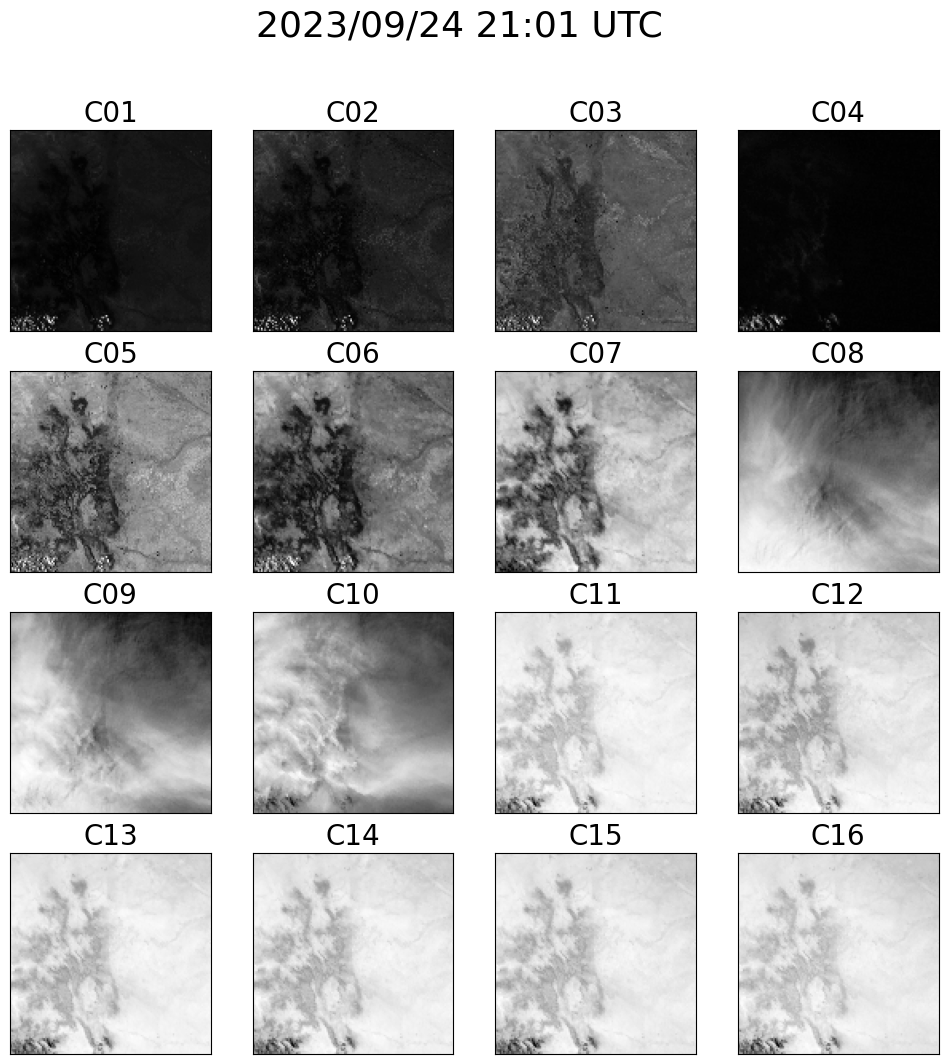

In [47]:
from plot_tifs import * 
plot_all_bands(fn_head)

### Composites

In [78]:
composites = ['airmass', 'true_color_raw', 'true_color','natural_color']

In [79]:
def create_composite(sat_fns, lat, lon, composites = ['cimss_true_color_sunz_rayleigh', 'airmass'], res=3000):
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    scn = get_scn(sat_fns, composites, extent, get_proj(), res)
    for composite in composites:
        data = get_RGB(scn, composite)
        save_data(data, composite, fn_head)
    return fn_head, scn
fn_head, scn = create_composite(sat_fns, lat, lon, composites)

2023/09/24 21:01 UTC


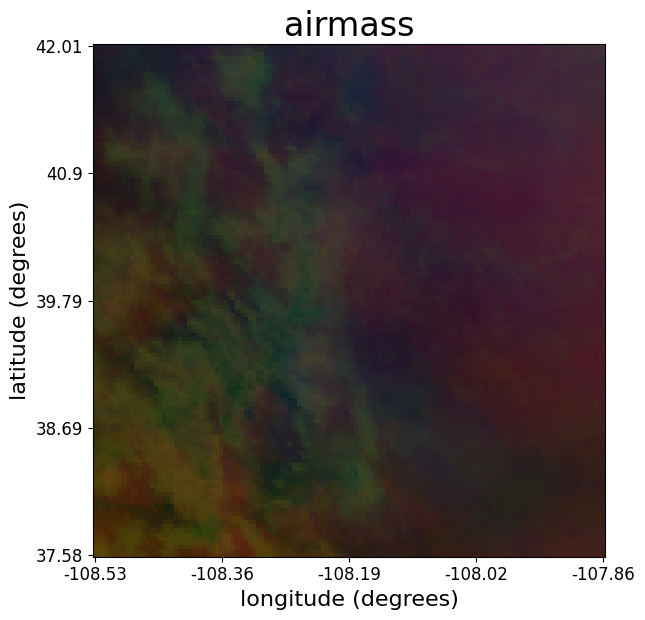

2023/09/24 21:01 UTC


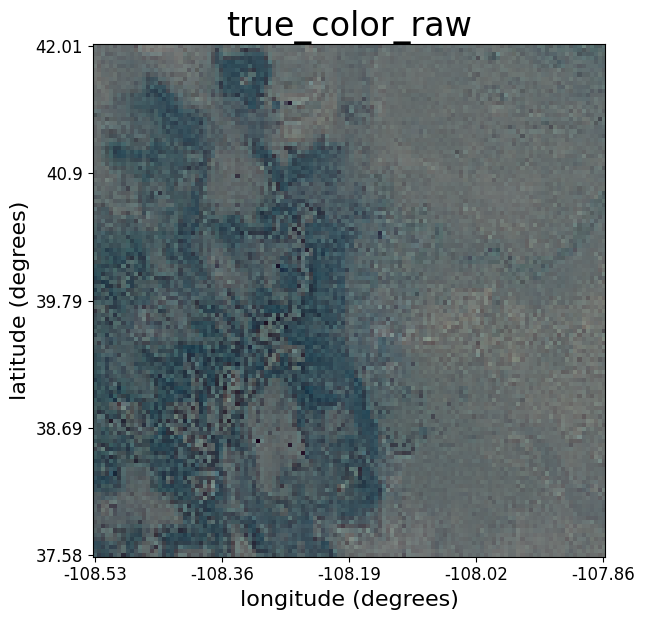

2023/09/24 21:01 UTC


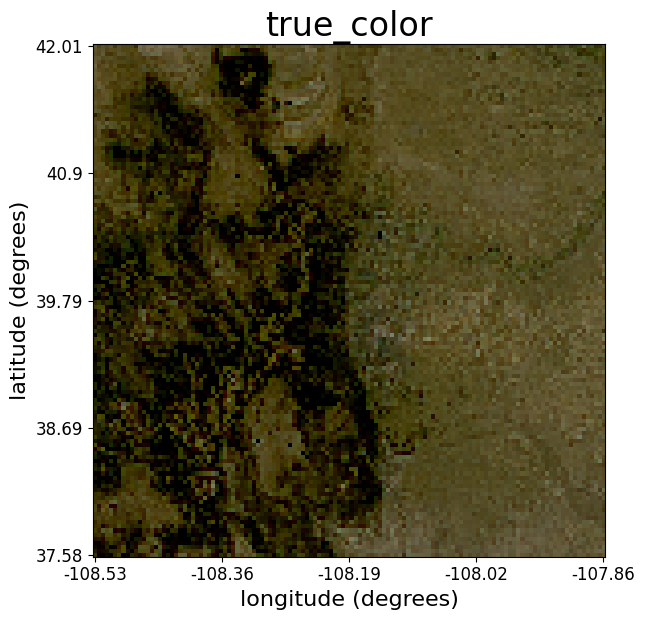

2023/09/24 21:01 UTC


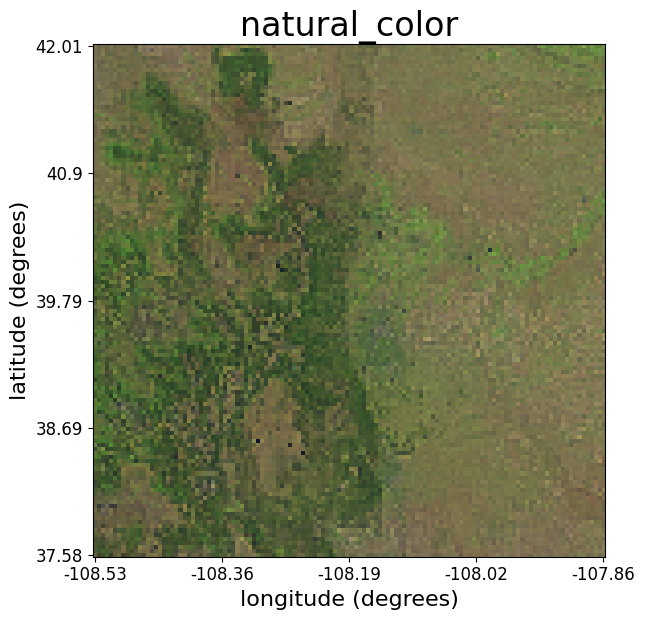

In [81]:
def plot_composite(composite, fn_head, data_loc="./data/"):
    data_fn = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB = skimage.io.imread(data_fn, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(RGB)
    plt.yticks(np.linspace(0,RGB.shape[0]-1,5), np.round(lat,2), fontsize=12)
    plt.ylabel('latitude (degrees)', fontsize=16)
    plt.xticks(np.linspace(0,RGB.shape[0]-1,5), np.round(lon,2), fontsize=12)
    plt.xlabel('longitude (degrees)', fontsize=16)
    plt.title(composite,fontsize=24)
    plt.tight_layout(pad=0)
    plt.show()

for composite in composites:
    plot_composite(composite, fn_head)